# Teste Processo Seletivo Kynetec

In [73]:
# Importar bibliotecas utilizadas
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

## 1) Acessar o sistema SIDRA do IBGE e fazer o download dos dados de área plantada da cultura da soja para os anos de 2019, 2020 e 2021 da Pesquisa Agrícola Municipal (PAM)

In [74]:
pam_df = pd.read_excel("tabela1612.xlsx")

O dado contou com pré-processamento após ser extraído da fonte, uma vez que não é disponibilizada versão CSV pronta para ingestão no código.

## 2) Acessar os dados da Conab sobre estimativa de Safra e filtra apenas os dados de Soja, para as safras 18/19, 19/20, 20/21 e 21/22, considerando apenas os dados do 12° levantamento.

In [75]:
conab_url = "https://portaldeinformacoes.conab.gov.br/downloads/arquivos/SerieHistoricaGraos.txt"
conab = pd.read_csv(conab_url, sep=';')
conab  = conab[conab["produto"].str.contains('SOJA')]

O dado foi extraído diretamente da URL fornecida sem qualquer pré-processamento.

## 3) Fazer uma análise comparativa, ao nível estadual e nacional, das áreas plantadas de soja apontadas pelo IBGE e pela CONAB para os anos de 2019 (18/19), 2020 (19/20) e 2021 (20/21).

In [76]:
# Agrupar CONAB por ano para todas as UFs e selecionaar anos 2018/2019, 2019/2020 e 2020/2021
by_year = conab.groupby('ano_agricola')['area_plantada_mil_ha'].sum()
by_year = DataFrame(by_year[-5:-2])
by_year.reset_index(inplace = True)
by_year['ano_agricola'] = by_year['ano_agricola'].str.replace(" ", "")

# Somar colunas 2019, 2020 e 2021 da PAM para obter área plantada anual segundo IBGE
cols  = pam_df.columns.drop('cd_mun').drop('mun')
pam_df[cols] = pam_df[cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype('int')
pam_df['uf'] = pam_df["mun"].str.split(' \(', 1).str[1].str[0:2]
pam_df['cd_mun'] = pam_df['cd_mun'].astype(str)

nm_cols = pam_df.select_dtypes(include=np.number).columns.tolist()
sums = []
for col in nm_cols:
    sums.append(pam_df[col].sum()/1000)
    
# Criar tabela agrupando as duas fontes de dado
by_year['pam'] = sums
by_year.columns = ['Ano Agrícola', 'Conab', 'IBGE']

Text(0, 0.5, 'Área plantada (mil hectares)')

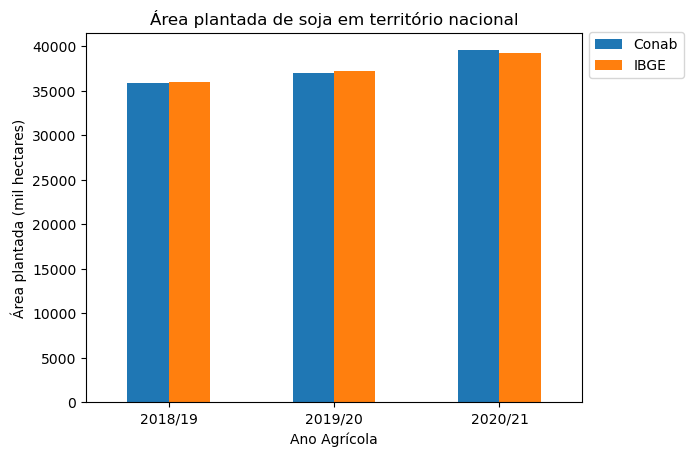

In [77]:
# Plotagem do dado agregado a nível nacional
ax = by_year.plot(x='Ano Agrícola', y=['Conab', 'IBGE'], kind="bar", rot=0)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.title.set_text('Área plantada de soja em território nacional')
ax.set_ylabel('Área plantada (mil hectares)', fontsize=10)

Aqui conclui-se que há relativa similaridade nos dados de ambas as fontes, uma vez que estão em ordem de grandeza semelhantes para as três safras analisadas.

In [78]:
# Selecionar safra '2018/19', '2019/20', '2020/21' CONAB e tornar o 'ano_agricola' coluna,
#para unir esta tabela com a tabela do IBGE
y = ['2018/19', '2019/20', '2020/21']
conab_by_uf = conab[conab['ano_agricola'].apply(lambda x: any([k in x for k in y]))]
conab_by_uf = pd.pivot_table(conab_by_uf, values = 'area_plantada_mil_ha', index='uf', columns = 'ano_agricola')

# Agregar área plantada IBGE por ano e UF
pam_by_uf = pam_df.groupby('uf').aggregate(\
    {'2021': 'sum', '2020': 'sum', '2019': 'sum'})/1000

# Unir as duas tabelas e renomear colunas
uf_df = pd.merge(conab_by_uf, pam_by_uf, left_index=True, right_index=True)
uf_df.columns = ['2019_conab', '2020_conab', '2021_conab',\
       '2021_pam', '2020_pam', '2019_pam']

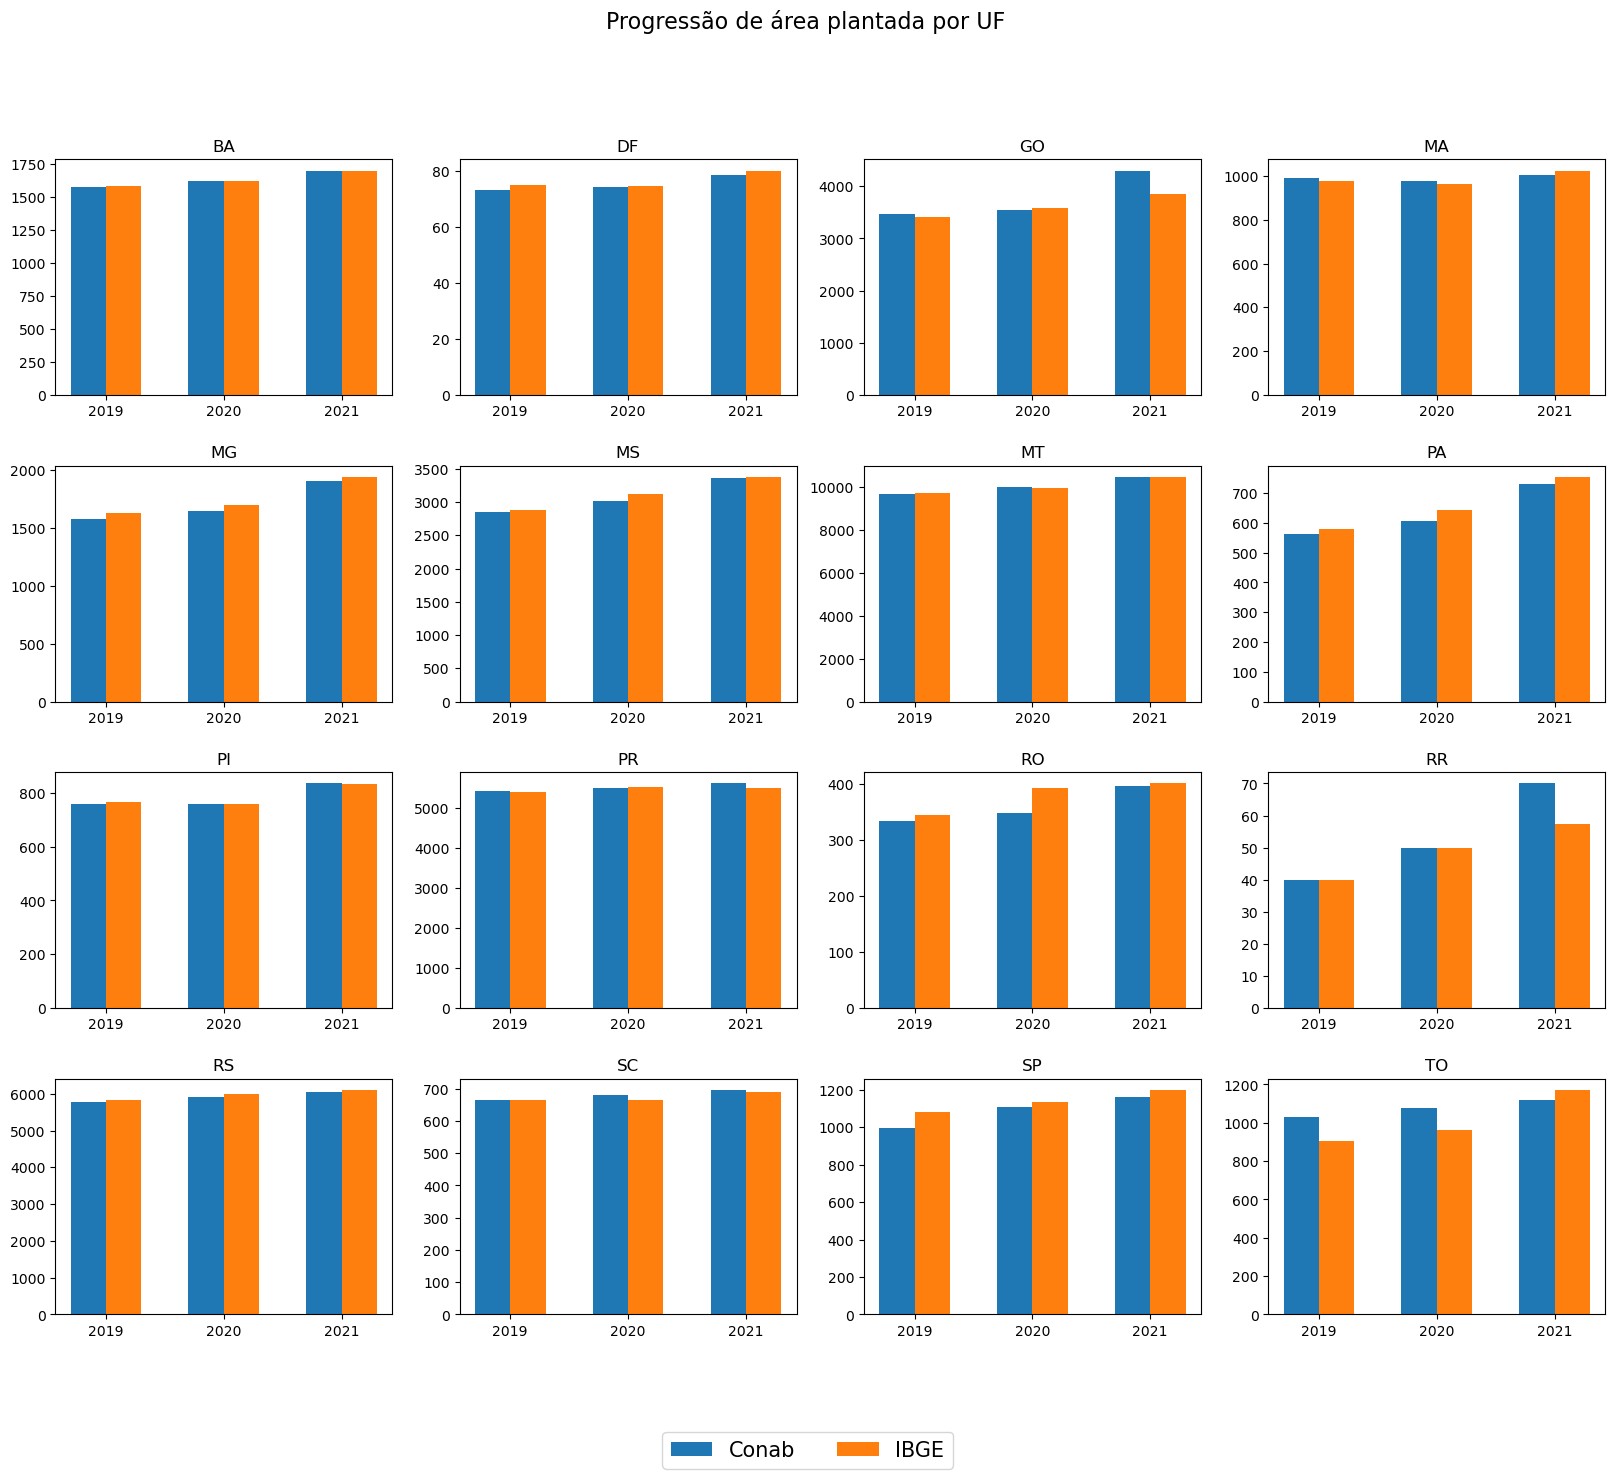

In [79]:
# Selcionar apenas UFs com ao menos um valor superior a 0
uf_df = uf_df[(uf_df > 25).any(1)]

ufs = list(uf_df.index.get_level_values(0).unique())

#Criação de subplots para cada UF.
fig, axs = plt.subplots(4,4, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.2)
fig.suptitle('Progressão de área plantada por UF', fontsize=16)
axs = axs.ravel()

for i in range(len(ufs)):
    group1 = uf_df.loc[(uf_df.index.get_level_values(0) == ufs[i])]
    conab_d = [group1.iloc[0]['2019_conab'],group1.iloc[0]['2020_conab'], group1.iloc[0]['2021_conab']]
    pam = [group1.iloc[0]['2019_pam'],group1.iloc[0]['2020_pam'], group1.iloc[0]['2021_pam']]
    plot_df = pd.DataFrame(list(zip(conab_d, pam)),\
                  columns=['Conab', 'IBGE'])
    #x = plot_df['Ano Agrícola'].values
    c = plot_df['Conab'].values
    ib = plot_df['IBGE'].values
    
    n = 3
    N = np.arange(n)
    width = 0.3
    axs[i].bar(N, c, width,label = 'Conab')
    axs[i].bar(N + width, ib,width, label = 'IBGE')
    axs[i].set_title(ufs[i])
    axs[i].set_xticks(N + width / 2, ('2019', '2020', '2021'))
    
plt.figlegend(labels = ["Conab", 'IBGE'], loc = 'lower center', ncol=2, labelspacing=0., fontsize= 15)    
#     x = group1.index.get_level_values(0)
#     y = group1['mean']
#     #plt.figure(figsize=(5,4))
#     axs[i].plot(x, y, c ="blue")
#     axs[i].fill_between(x=group1.index.get_level_values(0),y1=group1['min']\
#                      ,y2=group1['max'],data=group1,facecolor='GRAY', alpha=0.2)
#     #plt.xlabel('Week')
#     #plt.ylabel('Precipitation (mm)')
#     axs[i].set_title(ufs[i])
    #plt.show()
# ax = df_2019.plot(x='UF', y=['Conab', 'IBGE'], kind="bar", rot=0)
# ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
# ax.title.set_text('Área plantada de soja em território nacional')
# ax.set_ylabel('Área plantada (mil hectares)', fontsize=10)

Para que a visualização fosse mais efetiva, selecionou-se os 16 estados mais relevantes em termos de área plantada ao excluir as UFs que não tiveram mais de 25 mil hectares em ao menos uma safra em qualquer fonte de dado.

Como visto na análise do recorte nacional, há ambivalência em boa parte das UFs. Exceção seja feita ao estado de TO, um estado relevante, onde nas safras de 2018/2019 e 2019/2020 a Conab estimou a área plantada em cerca de 10% a mais do que o IBGE. Para o estado do MT, onde houve maior área plantada entre todas as UFs, vê-se que há equivalência entre as duas fontes, dando mais confiabilidade aos números obtidos.

## 4) Combinação das bases de dados:

### a. Utilizando os dados da PAM/IBGE, com os dados de área plantada, calcular a representatividade (em termos percentuais) de cada município dentro de cada estado para o ano de 2021.

In [80]:
# Selecionar safra 2021 PAM agregada pro UF e adicionar esta informação à tabela com dados municipais PAM.
#Calcula a representatividade que cada município tem dentro da soma total d
pam_21 = uf_df['2021_pam'].reset_index()
pam_21_mun = pd.merge(pam_df[['uf', 'cd_mun', 'mun', '2020','2021']], pam_21, on = 'uf', how = 'left')
pam_21_mun[['2020','2021']] = pam_21_mun[['2020','2021']]/1000 
pam_21_mun['percentage'] = pam_21_mun['2021']/pam_21_mun['2021_pam']
pam_21_mun

,uf,cd_mun,mun,2020,2021,2021_pam,percentage
0,RO,1100015,Alta Floresta D'Oeste (RO),0.450,1.072,400.459,0.002677
1,RO,1100023,Ariquemes (RO),7.782,6.979,400.459,0.017428
2,RO,1100031,Cabixi (RO),24.950,27.705,400.459,0.069183
3,RO,1100049,Cacoal (RO),1.000,2.160,400.459,0.005394
4,RO,1100056,Cerejeiras (RO),36.150,36.430,400.459,0.090971
...,...,...,...,...,...,...,...
5558,GO,5222005,Vianópolis (GO),41.000,41.000,3855.277,0.010635
5559,GO,5222054,Vicentinópolis (GO),21.000,24.500,3855.277,0.006355
5560,GO,5222203,Vila Boa (GO),0.250,1.800,3855.277,0.000467
5561,GO,5222302,Vila Propício (GO),16.700,22.950,3855.277,0.005953


### b. Utilizar essas porcentagens para alocar a área plantada estadual da Conab da safra 21/22 dentro dos municípios de cada estado.

In [81]:
# Selecionar safra 2021/22 da base CONAB e unir com tabela com porcentagem municipal de área palntada por UF, segundo IBGE
# Multiplciar porcentagem obtida em 2021 segundo IBGE e estimar porcentagem 2022 utilizando área plantada CONAB
conab_2122 = conab[conab["ano_agricola"].str.contains('2021/22')]

predict_2122 = pd.merge(pam_21_mun, conab_2122[['uf','area_plantada_mil_ha']], on = 'uf', how = 'left')
predict_2122['predict_2022'] = predict_2122['area_plantada_mil_ha']*predict_2122['percentage']
predict_2122

,uf,cd_mun,mun,2020,2021,2021_pam,percentage,area_plantada_mil_ha,predict_2022
0,RO,1100015,Alta Floresta D'Oeste (RO),0.450,1.072,400.459,0.002677,491.7,1.316246
1,RO,1100023,Ariquemes (RO),7.782,6.979,400.459,0.017428,491.7,8.569103
2,RO,1100031,Cabixi (RO),24.950,27.705,400.459,0.069183,491.7,34.017336
3,RO,1100049,Cacoal (RO),1.000,2.160,400.459,0.005394,491.7,2.652137
4,RO,1100056,Cerejeiras (RO),36.150,36.430,400.459,0.090971,491.7,44.730250
...,...,...,...,...,...,...,...,...,...
5558,GO,5222005,Vianópolis (GO),41.000,41.000,3855.277,0.010635,4393.6,46.724943
5559,GO,5222054,Vicentinópolis (GO),21.000,24.500,3855.277,0.006355,4393.6,27.921003
5560,GO,5222203,Vila Boa (GO),0.250,1.800,3855.277,0.000467,4393.6,2.051339
5561,GO,5222302,Vila Propício (GO),16.700,22.950,3855.277,0.005953,4393.6,26.154572


### c. Fazer uma análise comparativa da evolução de área das 3 últimas safras (19/20, 20/21 e 21/22) dentro do município com código IBGE = 5100201.

Text(0, 0.5, 'mil hectares')

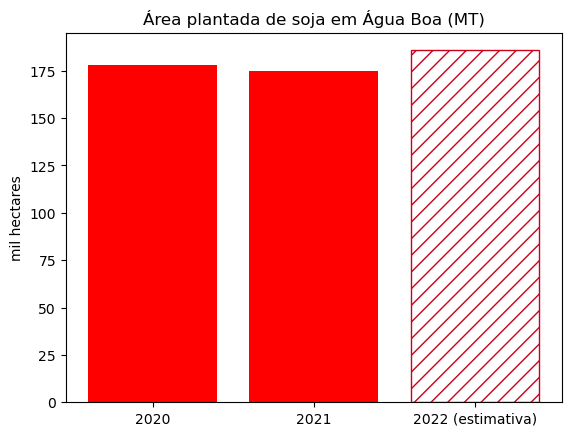

In [82]:
mun_analysis = predict_2122[predict_2122['cd_mun'] == '5100201']
#cols = []
data = mun_analysis[['2020', '2021', 'predict_2022']].iloc[0].to_list()
cols = ['2020', '2021', '2022 (estimativa)']

bars = plt.bar(cols, data, color ="red")
patterns = ['', '', '//']

for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)
    if pattern == '//':
        bar.set_edgecolor([0.8,0,0.1])
        bar.set_facecolor([1.0,1.0,1.0])
plt.title('Área plantada de soja em {}'.format(mun_analysis.iloc[0]['mun']))
plt.ylabel('mil hectares')

In [83]:
c1 = round((data[1]/data[0] - 1)*100, 2)*-1
c2 = round((data[2]/data[1] -1)*100,2)

Finalmente, se vê que que o município de Água Boa reduziu área plantada de 2020 para 2021, registrando uma queda de 1,69%.

A estimativa da área plantada de 2022 feita com base na percentagem que este município representou na safra de 2021 em relação ao estado segundo o IBGE multiplicada pela área plantada registrada na Conab para aquele ano pode ser questionável, uma vez que não foi feita uma investigação sobre as metodologias utilizadas por cada instituto na geração dos dados. No entanto, como se constata certa ambivalência nos dados obtidos por ambas as fontes no estado do MT, onde o município se insere, pode se dizer que trata-se de uma estimativa válida.

Sendo assim, espera-se que o município tenha registrado aumento de 6,18% em sua área plantada de soja no ano de 2022. 

In [1]:
!jupyter nbconvert --to html kynetec_teste.ipynb --no-input --execute

[NbConvertApp] Converting notebook kynetec_teste.ipynb to html
[NbConvertApp] Writing 795779 bytes to kynetec_teste.html
